#### Imports

In [28]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


### Synthetic data generation

In [27]:
np.random.seed(42)
n_samples = 2000

floor_area = np.random.uniform(30, 200, n_samples)
num_rooms = np.random.randint(1, 7, n_samples)
building_type = np.random.choice(["apartment", "independent"], n_samples)
climate_zone = np.random.choice(["hot", "moderate", "cool"], n_samples)
elec_kwh = np.random.uniform(50, 600, n_samples)
lpg_kg = np.random.uniform(0, 40, n_samples)
ac_hours = np.random.uniform(0, 8, n_samples)
occupants = np.random.randint(1, 7, n_samples)

co2_kg = (
    elec_kwh * 0.82
    + lpg_kg * 2.95
    + floor_area * 0.3
    + ac_hours * 5.0
    + occupants * 10.0
    + np.random.normal(0, 50, n_samples)
)


#### df.head() and Training loop → results_df table preview

In [29]:
target = "co2_kg"
df = pd.DataFrame({
    "floor_area": floor_area,
    "num_rooms": num_rooms,
    "building_type": building_type,
    "climate_zone": climate_zone,
    "elec_kwh": elec_kwh,
    "lpg_kg": lpg_kg,
    "ac_hours": ac_hours,
    "occupants": occupants,
    "co2_kg": co2_kg
})
X = df.drop(columns=[target])
y = df[target]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "XGBRegressor": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
    ),
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    results.append((name, mae, rmse, r2))

results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"])
results_df


C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Model,MAE,RMSE,R2
0,LinearRegression,40.683872,49.834711,0.879601
1,RandomForest,42.848687,52.932668,0.864166
2,XGBRegressor,42.743796,52.200644,0.867897


#### Model comparison bar chart → model_comparison.png

C:\Users\tapod\AppData\Local\Temp\ipykernel_22280\2330932279.py:29: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\tapod\AppData\Local\Temp\ipykernel_22280\2330932279.py:30: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig("model_comparison.png", dpi=300, bbox_inches="tight")
C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


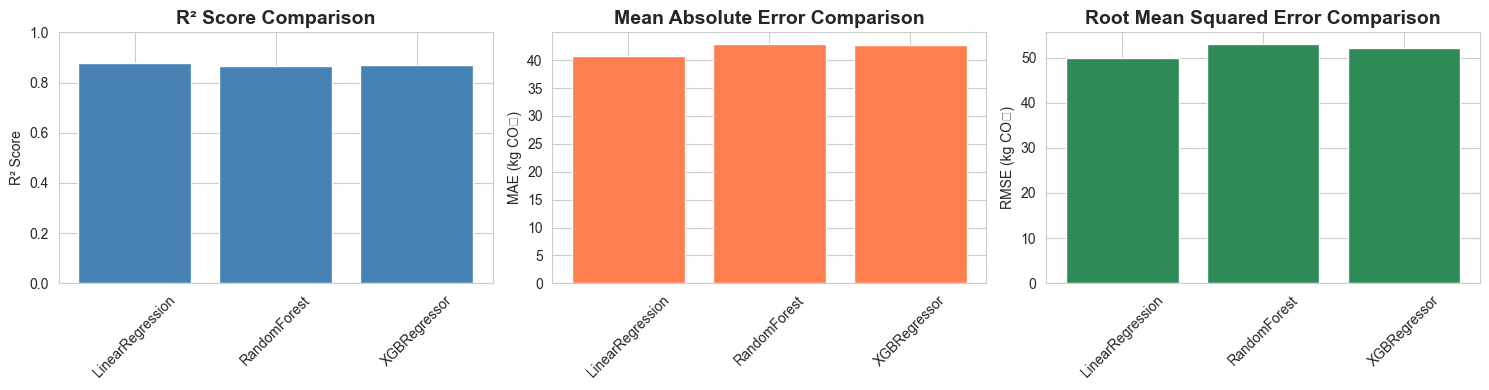

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models = ["LinearRegression", "RandomForest", "XGBRegressor"]
r2_scores = [results_df[results_df["Model"] == m]["R2"].values[0] for m in models]
mae_scores = [results_df[results_df["Model"] == m]["MAE"].values[0] for m in models]
rmse_scores = [results_df[results_df["Model"] == m]["RMSE"].values[0] for m in models]

axes[0].bar(models, r2_scores, color="steelblue")
axes[0].set_title("R² Score Comparison", fontsize=14, fontweight="bold")
axes[0].set_ylabel("R² Score")
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis="x", rotation=45)

axes[1].bar(models, mae_scores, color="coral")
axes[1].set_title("Mean Absolute Error Comparison", fontsize=14, fontweight="bold")
axes[1].set_ylabel("MAE (kg CO₂)")
axes[1].tick_params(axis="x", rotation=45)

axes[2].bar(models, rmse_scores, color="seagreen")
axes[2].set_title("Root Mean Squared Error Comparison", fontsize=14, fontweight="bold")
axes[2].set_ylabel("RMSE (kg CO₂)")
axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


#### Predicted vs Actual plot → pred_vs_actual_lr.png

C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\tapod\AppData\Local\Temp\ipykernel_22280\951849556.py:17: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\tapod\AppData\Local\Temp\ipykernel_22280\951849556.py:18: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig("pred_vs_actual_lr.png", dpi=300, bbox_inches="tight")
C:\Users\tapod\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


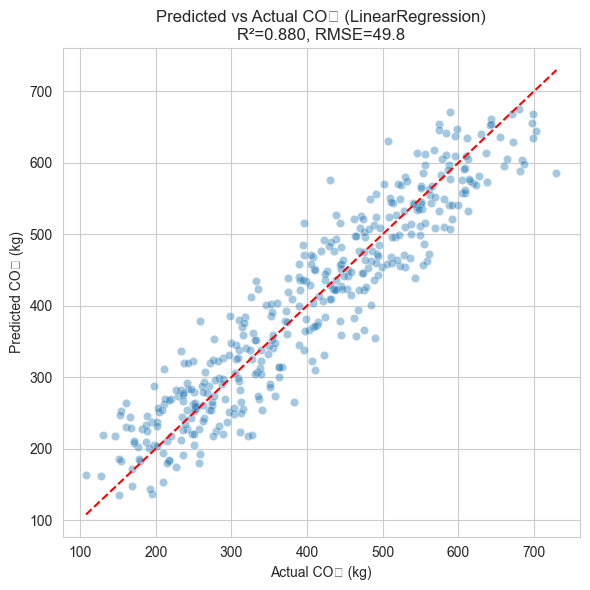

In [31]:
best_model = LinearRegression()
best_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", best_model)])
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.xlabel("Actual CO₂ (kg)")
plt.ylabel("Predicted CO₂ (kg)")
plt.title(f"Predicted vs Actual CO₂ (LinearRegression)\nR²={r2:.3f}, RMSE={rmse:.1f}")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.tight_layout()
plt.savefig("pred_vs_actual_lr.png", dpi=300, bbox_inches="tight")
plt.show()


#### Feature importance → feature_importance.png

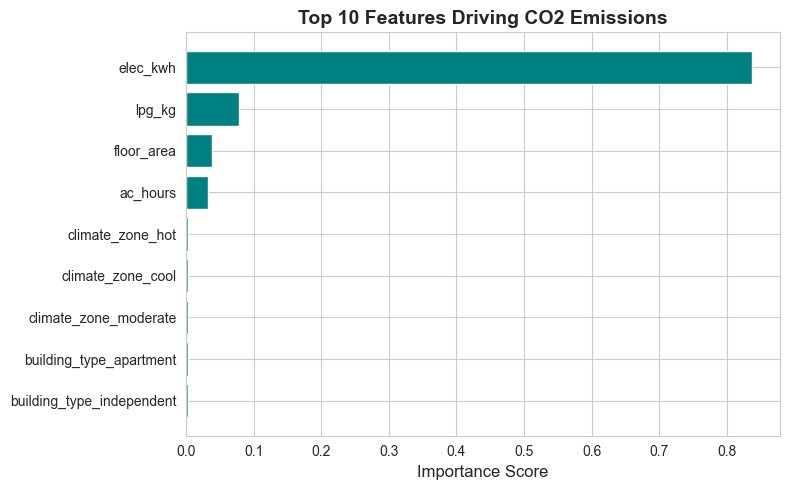

In [35]:
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", rf)])
rf_pipe.fit(X_train, y_train)

# Get feature names
ohe = rf_pipe.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

importances = rf_pipe.named_steps["model"].feature_importances_
feat_imp = pd.DataFrame(
    {"feature": feature_names, "importance": importances}
).sort_values("importance", ascending=False)

# Plot top 10
plt.figure(figsize=(8, 5))
plt.barh(feat_imp["feature"].head(10), feat_imp["importance"].head(10), color="teal")
plt.xlabel("Importance Score", fontsize=12)
plt.title("Top 10 Features Driving CO2 Emissions", fontsize=14, fontweight="bold")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()


#### RF trained on full data + joblib.dump → sdg13_rf_pipeline.pkl

In [33]:
import joblib

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", rf)])
rf_pipe.fit(X, y)  # train on full data for deployment

joblib.dump(rf_pipe, "sdg13_rf_pipeline.pkl")


['sdg13_rf_pipeline.pkl']